In [28]:
!pip install natsort
#VERY VERY VERY VERY IMPORTANT CHANGE THIS, TRAIN = 1 if TRAIN ONLY, ANY OTHER VALUE TESTS SESSION2
train = 2
#MODE IS FOR THE DATA TYPE, 1 = PADDED WITH NOISE, 2= CONCATENATED
mode = 2


In [29]:
import sklearn
import tensorflow as tf
import scipy.io
import numpy as np
import os
import natsort

In [30]:
!ls ..

bin	 datalab  home	 lib64	opt   run   sys		       tools
boot	 dev	  lib	 media	proc  sbin  tensorflow-1.15.2  usr
content  etc	  lib32  mnt	root  srv   tmp		       var


In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:

if train == 1 and mode == 1:
    DATAPATH = '/content/drive/Shareddrives/BCI_Project/bcidata_new/' #run this first
elif train == 1 and mode ==2:
    DATAPATH = '/content/drive/Shareddrives/BCI_Project/session1_concat/'
elif train ==2 and mode==2:
    DATAPATH = '/content/drive/Shareddrives/BCI_Project/session2_concat/' #try the concat session
elif train == 2 and mode == 1:
    DATAPATH = '/content/drive/Shareddrives/BCI_Project/session2/' #then switch to test the session2, but do not retrain the net
else:
    print("WRONG CONFIG")

In [33]:
files = natsort.natsorted(os.listdir(DATAPATH))

In [34]:
erp_data = [f for f in files if "ERP" in f]
mi_data = [f for f in files if "MI" in f]
ssvep_data = [f for f in files if "SSVEP" in f]
#################################################
train_data = [(erp_data[i], mi_data[i], ssvep_data[i]) for i in range(len(erp_data)) if "train" in erp_data[i]]
test_data = [(erp_data[i], mi_data[i], ssvep_data[i]) for i in range(len(erp_data)) if "test" in erp_data[i]]

In [35]:
mi_sample = scipy.io.loadmat(DATAPATH + mi_data[0])
ssvep_sample = scipy.io.loadmat(DATAPATH + ssvep_data[0])
erp_sample = scipy.io.loadmat(DATAPATH + erp_data[0])

mi_x = mi_sample['save_mi_te']['x'][0][0]
ssvep_x = ssvep_sample['save_ssvep_te']['x'][0][0]
erp_x = erp_sample['save_erp_te']['x'][0][0]

print(erp_x.shape, mi_x.shape, ssvep_x.shape)

(122, 100) (122, 100) (122, 100)


In [36]:
ssvep_x

array([[7.68, 12.31, -4.11, ..., 28.00, -7.64, -10.56],
       [9.15, 32.17, 15.16, ..., 36.14, 2.01, 0.06],
       [2.07, 4.46, 4.45, ..., 38.72, 29.81, -23.44],
       ...,
       [0.27, 0.22, 0.24, ..., 0.74, 0.53, 0.32],
       [0.25, 0.30, 0.27, ..., 0.20, 0.17, 0.42],
       [0.26, 0.65, 0.32, ..., 0.33, 0.37, 0.40]])

In [37]:
assert len(train_data) == len(test_data)

In [38]:
assert len(erp_data) == len(mi_data) == len(ssvep_data)

In [39]:
def padd_noised_x(arr, target_dim=110):
  target_dim = 110
  diff = target_dim - arr.shape[0]
  if diff > 0:
    padding = np.random.uniform(low =0, high = 2, size=(diff,arr.shape[1]))
    padded = np.concatenate([arr, padding], axis=0)
  else:
    padded = arr.copy()
  return padded

def padd_noised_x_alt(arr, paradigm):
  if paradigm == "ERP":
    padding = np.random.uniform(low =0, high = 2, size=(122 - arr.shape[0], arr.shape[1]))
    padded = np.concatenate([arr, padding], axis=0)
  elif paradigm == "MI":
    padding_left = np.random.uniform(low =0, high = 2, size=(110, arr.shape[1]))
    padding_right = np.random.uniform(low =0, high = 2, size=(4, arr.shape[1]))
    padded = np.concatenate([padding_left, arr, padding_right],
                            axis=0)
  elif paradigm == "SSVEP":
    padding = np.random.uniform(low =0, high = 2, size=(122 - arr.shape[0], arr.shape[1]))
    padded = np.concatenate([padding, arr], axis=0)
  else:
    print("Unknown paradigm")
    return None
  return padded

def padd_zeros_y(arr, paradigm):
  if paradigm == "ERP":
    padding = np.zeros((6, arr.shape[1]))
    padded = np.concatenate([arr, padding], axis=0)
  elif paradigm == "MI":
    padding_up = np.zeros((2, arr.shape[1]))
    padding_down = np.zeros((4, arr.shape[1]))
    padded = np.concatenate([padding_up, arr, padding_down],
                            axis=0)
  elif paradigm == "SSVEP":
    padding = np.zeros((4, arr.shape[1]))
    padded = np.concatenate([padding, arr], axis=0)
  else:
    print("Unknown paradigm")
    return None
  return padded

In [40]:
# Training data
train_x = []
train_y = []
for data in train_data:
  erp_file, mi_file, ssvep_file = data

  erp_mat = scipy.io.loadmat(DATAPATH + erp_file)
  # erp_x = erp_mat['save_erp_tr']['x'][0][0]
  if mode!=2:
      erp_x = padd_noised_x_alt(erp_mat['save_erp_tr']['x'][0][0], "ERP")
  else:
      erp_x = erp_mat['save_erp_tr']['x'][0][0]
  erp_y = padd_zeros_y(erp_mat['save_erp_tr']['y'][0][0], "ERP")

  mi_mat = scipy.io.loadmat(DATAPATH + mi_file)
  # mi_x = padd_zeros_x(mi_mat['save_mi_tr']['x'][0][0])
  if mode!=2 :
      mi_x = padd_noised_x_alt(mi_mat['save_mi_tr']['x'][0][0], "MI")
  else:
      mi_x = mi_mat['save_mi_tr']['x'][0][0]
  mi_y = padd_zeros_y(mi_mat['save_mi_tr']['y'][0][0], "MI")

  ssvep_mat = scipy.io.loadmat(DATAPATH + ssvep_file)
  # ssvep_x = padd_zeros_x(ssvep_mat['save_ssvep_tr']['x'][0][0])
  if mode!=2:
      ssvep_x = padd_noised_x_alt(ssvep_mat['save_ssvep_tr']['x'][0][0], "SSVEP")
  else:
      ssvep_x = ssvep_mat['save_ssvep_tr']['x'][0][0]
  ssvep_y = padd_zeros_y(ssvep_mat['save_ssvep_tr']['y'][0][0], "SSVEP")
  
  
  X = np.concatenate([erp_x, mi_x, ssvep_x], axis=1)
  Y = np.concatenate([erp_y, mi_y, ssvep_y], axis=1)

  train_x.append(X)
  train_y.append(Y)

# Testing data
test_x = []
test_y = []
for data in test_data:
  erp_file, mi_file, ssvep_file = data

  erp_mat = scipy.io.loadmat(DATAPATH + erp_file)
  # erp_x = erp_mat['save_erp_te']['x'][0][0]
  if mode!=2:
      erp_x = padd_noised_x_alt(erp_mat['save_erp_te']['x'][0][0], "ERP")
  else:
      erp_x = erp_mat['save_erp_te']['x'][0][0]
  erp_y = padd_zeros_y(erp_mat['save_erp_te']['y'][0][0], "ERP")

  mi_mat = scipy.io.loadmat(DATAPATH + mi_file)
  # mi_x = padd_zeros_x(mi_mat['save_mi_te']['x'][0][0])
  if mode!=2:
      mi_x = padd_noised_x_alt(mi_mat['save_mi_te']['x'][0][0], "MI")
  else:
      mi_x = mi_mat['save_mi_te']['x'][0][0]
  mi_y = padd_zeros_y(mi_mat['save_mi_te']['y'][0][0], "MI")

  ssvep_mat = scipy.io.loadmat(DATAPATH + ssvep_file)
  # ssvep_x = padd_zeros_x(ssvep_mat['save_ssvep_te']['x'][0][0])
  if mode!=2:
      ssvep_x = padd_noised_x_alt(ssvep_mat['save_ssvep_te']['x'][0][0], "SSVEP")
  else:
      ssvep_x = ssvep_mat['save_ssvep_te']['x'][0][0]
  ssvep_y = padd_zeros_y(ssvep_mat['save_ssvep_te']['y'][0][0], "SSVEP")

  X = np.concatenate([erp_x, mi_x, ssvep_x], axis=1)
  Y = np.concatenate([erp_y, mi_y, ssvep_y], axis=1)

  test_x.append(X)
  test_y.append(Y)

In [41]:
X_tr = np.concatenate(train_x, axis=1).T
Y_tr = np.concatenate(train_y, axis=1).T
Y_tr = [np.argmax(el) for el in Y_tr]

X_te = np.concatenate(test_x, axis=1).T
Y_te = np.concatenate(test_y, axis=1).T
Y_te = [np.argmax(el) for el in Y_te]

In [42]:
from sklearn.preprocessing import StandardScaler, RobustScaler

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

X_tr_scaled = rob_scaler.fit_transform(X_tr)
X_te_scaled = rob_scaler.fit_transform(X_te)

In [43]:
train_size = len(X_tr_scaled)
y_vector = np.concatenate(train_y, axis=1).T
print(X_tr_scaled[1000],y_vector[1000])
print(train_size)

[0.82 1.10 0.70 0.68 0.76 1.07 0.57 0.67 0.61 0.85 1.04 1.05 0.47 0.42
 0.56 1.00 0.48 0.61 0.47 0.78 0.89 0.94 0.52 0.40 0.59 0.96 0.44 0.50
 0.47 0.83 0.75 0.76 0.49 0.45 0.55 0.87 0.44 0.42 0.58 0.80 0.92 0.65
 0.27 0.11 0.38 0.77 0.34 0.39 0.36 0.59 0.79 0.97 0.57 0.52 0.68 0.97
 0.47 0.49 0.64 0.81 0.93 0.79 0.34 0.23 0.53 0.92 0.40 0.42 0.32 0.64
 0.88 0.89 0.63 0.39 0.53 0.79 0.18 0.21 0.52 0.77 0.53 0.51 0.22 0.10
 0.29 0.37 0.12 0.11 0.37 0.47 0.46 0.39 0.21 0.15 0.33 0.33 0.16 0.16
 0.54 0.61 0.63 0.48 0.11 -0.12 0.25 0.57 0.38 0.31 0.41 0.47 0.08 -0.38
 0.07 0.16 2.34 2.31 1.88 2.56 0.28 -0.04 -0.11 -1.10] [0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00]
16200


In [44]:
import torch
import torchvision
import torchvision.transforms as transforms

In [45]:
classes = ["target", "nontarget", "right arm", "left arm", "up", "left", "right", "down"]
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
feature_size, output_size = X_tr_scaled.shape[1], y_vector.shape[1]
print(feature_size,output_size)
if train ==1:
    print('TRAINING')
else:
    print("WE ARE NOT TRAINING ON SESSION1, THIS IS SESSION 2")

Using cpu device
122 8
WE ARE NOT TRAINING ON SESSION1, THIS IS SESSION 2


In [46]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(feature_size, feature_size*4)
        self.fc2 = nn.Linear(feature_size*4, feature_size*3)
        self.fc3 = nn.Linear(feature_size*3, feature_size*2)
        self.fc4 = nn.Linear(feature_size*2, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        #x = torch.sigmoid(x)
        return x

if train ==1:
    print('TRAINING')
    net = Net()
else:
    print("WE ARE NOT TRAINING ON SESSION1, THIS IS SESSION 2")

WE ARE NOT TRAINING ON SESSION1, THIS IS SESSION 2


In [47]:
import torch.optim as optim

if train ==1:
    print('TRAINING')
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.0008, momentum=0.98)
else:
    print("WE ARE NOT TRAINING ON SESSION1, THIS IS SESSION 2")

WE ARE NOT TRAINING ON SESSION1, THIS IS SESSION 2


In [48]:
if train==1:
    if mode ==2:
        batch_size = 200
        epochs = 50
    else:
        batch_size = 20
        epochs = 15
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        batch_count = train_size/batch_size
        for i in range(int(batch_count)):

            torched_x = torch.FloatTensor(X_tr_scaled[i*batch_size:(i+1)*batch_size])
            torched_y = torch.tensor(Y_tr[i*batch_size:(i+1)*batch_size]).long()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(torched_x)
            loss = criterion(outputs, torched_y)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i == batch_count-1:    # print every 5000 mini-batches
                print('[epoch %d] loss: %.3f' % (epoch + 1, running_loss / train_size))
                running_loss = 0.0

    print('Finished Training')
else:
    print("WE ARE NOT TRAINING ON SESSION1, THIS IS SESSION 2")


WE ARE NOT TRAINING ON SESSION1, THIS IS SESSION 2


In [49]:
hits = 0
predictions = []
test_length = len(X_te_scaled)
for i in range(test_length):
    test_x = torch.FloatTensor([X_te_scaled[i]])
    test_y = Y_te[i]
    test_outputs = net(test_x).tolist()
    value = [np.argmax(el) for el in test_outputs][0]
    predictions.append(value)
    if test_y == value:
        hits+=1

print("There are",hits,"hits out of",test_length)
print(hits/test_length)
if train ==1:
    print('TRAINING')
else:
    print("WE ARE NOT TRAINING ON SESSION1, THIS IS SESSION 2")

There are 11351 hits out of 16200
0.700679012345679
WE ARE NOT TRAINING ON SESSION1, THIS IS SESSION 2


In [50]:
#Example usage
import random
for i in range(10):
    index = random.randint(0, test_length-1)
    test_x = torch.FloatTensor([X_te_scaled[index]])
    test_y = Y_te[index]
    test_outputs = net(test_x).tolist()
    value = [np.argmax(el) for el in test_outputs][0]
    print(classes[value], value, test_y,classes[test_y])
if train ==1:
    print('TRAINING')
else:
    print("WE ARE NOT TRAINING ON SESSION1, THIS IS SESSION 2")

left arm 3 6 right
nontarget 1 1 nontarget
nontarget 1 1 nontarget
down 7 1 nontarget
right 6 6 right
down 7 7 down
up 4 4 up
right arm 2 2 right arm
right arm 2 2 right arm
nontarget 1 1 nontarget
WE ARE NOT TRAINING ON SESSION1, THIS IS SESSION 2


In [51]:
from sklearn.metrics import confusion_matrix
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
conf_matrix = confusion_matrix(Y_te, predictions, normalize = 'pred')

conf_matrix

array([[0.25, 0.12, 0.04, 0.03, 0.00, 0.00, 0.01, 0.02],
       [0.16, 0.60, 0.16, 0.15, 0.02, 0.03, 0.03, 0.09],
       [0.31, 0.12, 0.66, 0.16, 0.03, 0.01, 0.03, 0.05],
       [0.20, 0.12, 0.08, 0.59, 0.00, 0.04, 0.02, 0.04],
       [0.00, 0.01, 0.01, 0.01, 0.94, 0.01, 0.00, 0.00],
       [0.00, 0.01, 0.01, 0.02, 0.00, 0.90, 0.00, 0.01],
       [0.02, 0.01, 0.01, 0.01, 0.00, 0.00, 0.91, 0.00],
       [0.05, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.79]])

<function matplotlib.pyplot.show>

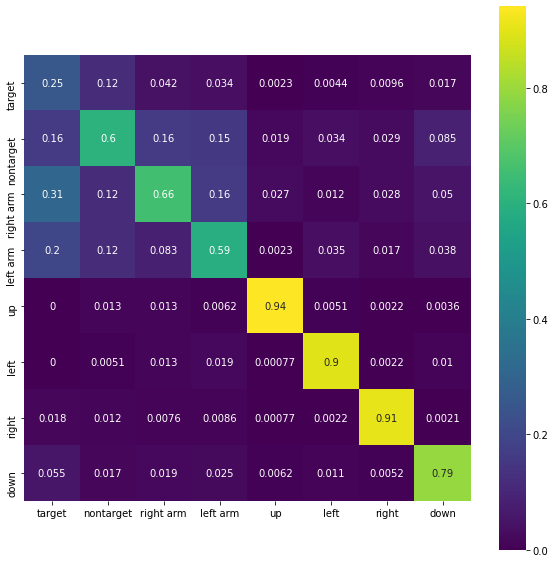

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(conf_matrix,  xticklabels = classes, yticklabels = classes, annot=True, cmap="viridis", square=True, ax=ax)
plt.show

In [53]:
Y_te_class = []
predictions_class=[]
for i in range(len(Y_te)):
    if Y_te[i] ==0 or Y_te[i] ==1:
        Y_te_class.append(0)
    elif Y_te[i] ==2 or Y_te[i] ==3:
        Y_te_class.append(1)
    else:
        Y_te_class.append(2)

    if predictions[i] ==0 or predictions[i] ==1:
        predictions_class.append(0)
    elif predictions[i] ==2 or predictions[i] ==3:
        predictions_class.append(1)
    else:
        predictions_class.append(2)

<function matplotlib.pyplot.show>

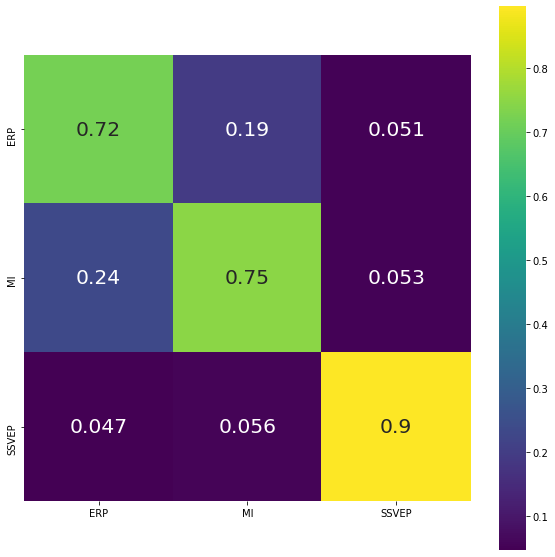

In [54]:
conf_matrix2 = confusion_matrix(Y_te_class, predictions_class, normalize = 'pred')
classes2 = ["ERP","MI","SSVEP"]
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(conf_matrix2,  xticklabels = classes2, yticklabels = classes2, annot=True, cmap="viridis", square=True, ax=ax, annot_kws={"size": 35 / np.sqrt(len(conf_matrix2))})

plt.show